# Visual Question Answering

## Problem Statement

Visual Question Answering (VQA) is the task of answering open-ended questions based on an image. VQA has many applications: Medical VQA, Education purposes, for surveillance and numerous other applications. In this assignment we will use VizWiz dataset, this dataset was constructed to train models to help visually impaired people.
In the words of creators of VizWiz: “we introduce the visual question answering (VQA) dataset coming from this population, which we call VizWiz-VQA. It originates from a natural visual question answering setting where blind people each took an image and recorded a spoken question about it, together with 10 crowdsourced answers per visual question.”

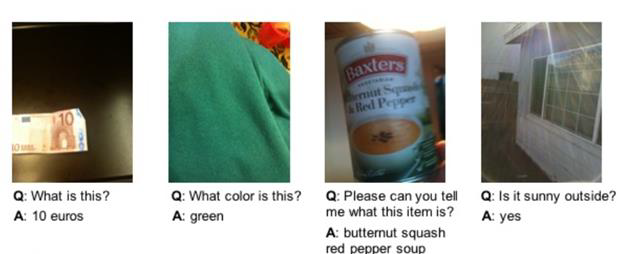

_Figure 1: Sample examples from the VizWiz dataset_

**Importing Libraries**

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import requests
from pathlib import Path
from PIL import Image
from pkg_resources import packaging
from collections import Counter
from itertools import combinations
from io import BytesIO

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import average_precision_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

%matplotlib inline

time: 4.8 ms (started: 2023-06-25 17:08:27 +00:00)


In [2]:
!pip install ipython-autotime
%load_ext autotime

time: 725 µs (started: 2023-06-25 15:50:57 +00:00)


## 1. Download the Dataset and Data analysis (20 Points)

a. VizWiz is a VQA dataset that contains 20,500 images/question pairs. Each image has its corresponding question and 10 answers to this question.
>i. 20,523 training image/question pairs
<br/>ii. 205,230 training answer/answer confidence pairs
<br/>iii. 4,319 validation image/question pairs
<br/>iv. 43,190 validation answer/answer confidence pairs

b. The dataset can be found at the following link:
https://www.kaggle.com/datasets/ingbiodanielh/vizwiz

c. Take 0.05 of the training data as test data.

d. You will need to analyze the data and show comprehensible histogram of the data.

e. Using Kaggle you will be able to mount the data instantly without any hustle.

**f. Don’t forget to set seed 42 and stratify to true and remember that the answer/answer confidence pairs correspond to the images and questions.**

**Utility Functions**

In [3]:
def explode_df(df, col):
    df = df.explode(col).reset_index(drop=True)
    df = df.merge(pd.json_normalize(df[col]), left_index=True, right_index=True).drop(col, axis=1)
    return df

time: 839 µs (started: 2023-06-25 15:50:57 +00:00)


**Loading the Dataset**

In [4]:
os.listdir('/kaggle/input/vizwiz/data/Annotations')

['._val.json',
 '._test.json',
 'README.txt',
 'train.json',
 'test.json',
 '._README.txt',
 '._train.json',
 'val.json']

time: 18 ms (started: 2023-06-25 15:50:57 +00:00)


In [5]:
train_test = pd.read_json("/kaggle/input/vizwiz/data/Annotations/train.json", orient="records")
val = pd.read_json("/kaggle/input/vizwiz/data/Annotations/val.json", orient="records")

time: 1.13 s (started: 2023-06-25 15:50:57 +00:00)


**Splitting Train and Test Sets**

In [6]:
train_test['answerable_answer_type'] = train_test['answerable'].astype(str) + "_" + train_test['answer_type'].astype(str)

time: 35.4 ms (started: 2023-06-25 15:50:58 +00:00)


In [7]:
train, test, _, _ = train_test_split(train_test, train_test['answerable_answer_type'], test_size=0.05, random_state=42, stratify=train_test['answerable_answer_type'])

time: 66.4 ms (started: 2023-06-25 15:50:59 +00:00)


In [8]:
train.drop(columns=['answerable_answer_type'], inplace=True)
test.drop(columns=['answerable_answer_type'], inplace=True)

time: 9.2 ms (started: 2023-06-25 15:50:59 +00:00)


In [9]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

time: 674 µs (started: 2023-06-25 15:50:59 +00:00)


In [10]:
train

,answerable,image,question,answer_type,answers
0,1,VizWiz_train_000000018631.jpg,what is this?,other,"[{'answer_confidence': 'no', 'answer': 'unsuit..."
1,1,VizWiz_train_000000018403.jpg,What kind of yogurt is this?,other,"[{'answer_confidence': 'maybe', 'answer': 'blu..."
2,1,VizWiz_train_000000008972.jpg,Can you describe this picture?,unanswerable,"[{'answer_confidence': 'yes', 'answer': 'unans..."
3,0,VizWiz_train_000000017856.jpg,What is this green?,unanswerable,"[{'answer_confidence': 'no', 'answer': 'unansw..."
4,1,VizWiz_train_000000000850.jpg,What kind of pop is this?,other,"[{'answer_confidence': 'yes', 'answer': '7 up'..."
...,...,...,...,...,...
18995,1,VizWiz_train_000000013757.jpg,"Hello, would you please so kind to tell me wha...",unanswerable,"[{'answer_confidence': 'maybe', 'answer': 'str..."
18996,1,VizWiz_train_000000016587.jpg,What color is this,other,"[{'answer_confidence': 'yes', 'answer': 'white..."
18997,1,VizWiz_train_000000007644.jpg,what kind of drink is this,other,"[{'answer_confidence': 'yes', 'answer': 'orang..."
18998,0,VizWiz_train_000000016074.jpg,What is this box?,unanswerable,"[{'answer_confidence': 'yes', 'answer': 'unsui..."


time: 83 ms (started: 2023-06-25 15:50:59 +00:00)


In [11]:
val

,answerable,image,question,answer_type,answers
0,0,VizWiz_val_000000028000.jpg,What's this?,unanswerable,"[{'answer_confidence': 'yes', 'answer': 'unsui..."
1,0,VizWiz_val_000000028001.jpg,What is this?,unanswerable,"[{'answer': 'unanswerable', 'answer_confidence..."
2,1,VizWiz_val_000000028002.jpg,What is this?,other,"[{'answer_confidence': 'yes', 'answer': 'unsui..."
3,1,VizWiz_val_000000028003.jpg,What is this?,unanswerable,"[{'answer_confidence': 'yes', 'answer': 'unsui..."
4,0,VizWiz_val_000000028004.jpg,What does it say on this card?,unanswerable,"[{'answer_confidence': 'yes', 'answer': 'unsui..."
...,...,...,...,...,...
3168,1,VizWiz_val_000000031168.jpg,what is this?,other,"[{'answer_confidence': 'yes', 'answer': 'salad..."
3169,0,VizWiz_val_000000031169.jpg,Is this modern?,unanswerable,"[{'answer_confidence': 'maybe', 'answer': 'uns..."
3170,0,VizWiz_val_000000031170.jpg,I need to buy this battery for my cordless pho...,unanswerable,"[{'answer_confidence': 'yes', 'answer': 'unans..."
3171,1,VizWiz_val_000000031171.jpg,What kind of mix is this?,other,"[{'answer_confidence': 'maybe', 'answer': 'cak..."


time: 74.6 ms (started: 2023-06-25 15:50:59 +00:00)


In [12]:
test

,answerable,image,question,answer_type,answers
0,0,VizWiz_train_000000012206.jpg,You can tell me what kind of perfume is this? ...,unanswerable,"[{'answer': 'unsuitable', 'answer_confidence':..."
1,1,VizWiz_train_000000007799.jpg,What is this?,other,"[{'answer_confidence': 'yes', 'answer': 'fire ..."
2,0,VizWiz_train_000000004613.jpg,What catalog is this?,unanswerable,"[{'answer_confidence': 'maybe', 'answer': 'una..."
3,1,VizWiz_train_000000002279.jpg,What is this?,unanswerable,"[{'answer': 'ice cream lid', 'answer_confidenc..."
4,1,VizWiz_train_000000012052.jpg,What is in the bottle?,other,"[{'answer_confidence': 'yes', 'answer': 'sanit..."
...,...,...,...,...,...
995,1,VizWiz_train_000000012905.jpg,"Alright, can you tell me what flavor this is p...",other,"[{'answer_confidence': 'yes', 'answer': 'cream..."
996,1,VizWiz_train_000000000389.jpg,Can you please tell me what this is?,other,"[{'answer': 'lotion', 'answer_confidence': 'ma..."
997,1,VizWiz_train_000000014106.jpg,What is in this bottle?,other,"[{'answer_confidence': 'yes', 'answer': 'cherr..."
998,1,VizWiz_train_000000017834.jpg,What is this item?,other,"[{'answer': 'craft', 'answer_confidence': 'may..."


time: 75.8 ms (started: 2023-06-25 15:50:59 +00:00)


**Exploratoy Data Analysis**

In [13]:
df = pd.concat([train, test, val])
df.reset_index(drop=True, inplace=True)
df

,answerable,image,question,answer_type,answers
0,1,VizWiz_train_000000018631.jpg,what is this?,other,"[{'answer_confidence': 'no', 'answer': 'unsuit..."
1,1,VizWiz_train_000000018403.jpg,What kind of yogurt is this?,other,"[{'answer_confidence': 'maybe', 'answer': 'blu..."
2,1,VizWiz_train_000000008972.jpg,Can you describe this picture?,unanswerable,"[{'answer_confidence': 'yes', 'answer': 'unans..."
3,0,VizWiz_train_000000017856.jpg,What is this green?,unanswerable,"[{'answer_confidence': 'no', 'answer': 'unansw..."
4,1,VizWiz_train_000000000850.jpg,What kind of pop is this?,other,"[{'answer_confidence': 'yes', 'answer': '7 up'..."
...,...,...,...,...,...
23168,1,VizWiz_val_000000031168.jpg,what is this?,other,"[{'answer_confidence': 'yes', 'answer': 'salad..."
23169,0,VizWiz_val_000000031169.jpg,Is this modern?,unanswerable,"[{'answer_confidence': 'maybe', 'answer': 'uns..."
23170,0,VizWiz_val_000000031170.jpg,I need to buy this battery for my cordless pho...,unanswerable,"[{'answer_confidence': 'yes', 'answer': 'unans..."
23171,1,VizWiz_val_000000031171.jpg,What kind of mix is this?,other,"[{'answer_confidence': 'maybe', 'answer': 'cak..."


time: 78.7 ms (started: 2023-06-25 15:50:59 +00:00)


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23173 entries, 0 to 23172
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   answerable   23173 non-null  int64 
 1   image        23173 non-null  object
 2   question     23173 non-null  object
 3   answer_type  23173 non-null  object
 4   answers      23173 non-null  object
dtypes: int64(1), object(4)
memory usage: 905.3+ KB
time: 71.3 ms (started: 2023-06-25 15:50:59 +00:00)


In [15]:
df['answerable_answer_type'] = df['answerable'].astype(str) + "_" + df['answer_type'].astype(str)

time: 37.3 ms (started: 2023-06-25 15:50:59 +00:00)


<Axes: >

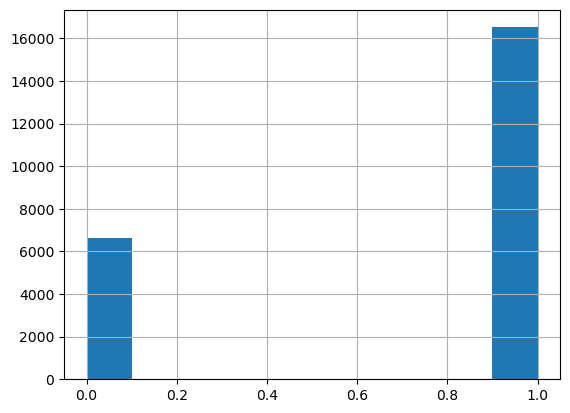

time: 540 ms (started: 2023-06-25 15:50:59 +00:00)


In [16]:
df['answerable'].hist()

<Axes: >

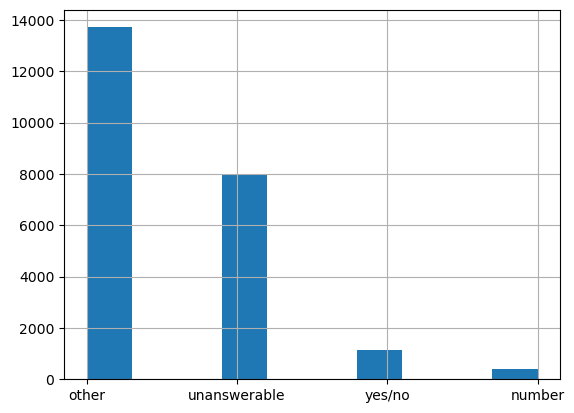

time: 330 ms (started: 2023-06-25 15:51:00 +00:00)


In [17]:
df['answer_type'].hist()

<Axes: >

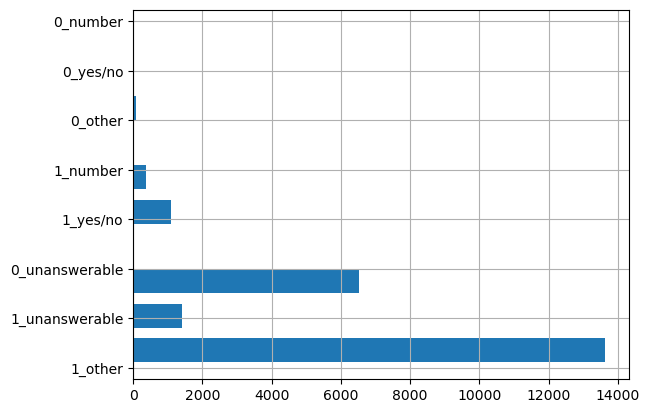

time: 388 ms (started: 2023-06-25 15:51:00 +00:00)


In [18]:
df['answerable_answer_type'].hist(orientation="horizontal", rwidth=0.7)

In [19]:
explode_df(val, 'answers')

,answerable,image,question,answer_type,answer_confidence,answer
0,0,VizWiz_val_000000028000.jpg,What's this?,unanswerable,yes,unsuitable
1,0,VizWiz_val_000000028000.jpg,What's this?,unanswerable,yes,unsuitable
2,0,VizWiz_val_000000028000.jpg,What's this?,unanswerable,maybe,beans
3,0,VizWiz_val_000000028000.jpg,What's this?,unanswerable,yes,unanswerable
4,0,VizWiz_val_000000028000.jpg,What's this?,unanswerable,yes,unsuitable
...,...,...,...,...,...,...
31725,1,VizWiz_val_000000031172.jpg,What kind of spice is this?,other,maybe,masala
31726,1,VizWiz_val_000000031172.jpg,What kind of spice is this?,other,yes,unsuitable
31727,1,VizWiz_val_000000031172.jpg,What kind of spice is this?,other,yes,garam marsala
31728,1,VizWiz_val_000000031172.jpg,What kind of spice is this?,other,maybe,masala


time: 275 ms (started: 2023-06-25 15:51:00 +00:00)


In [20]:
df3 = explode_df(df, 'answers')
df3.drop(columns=['answerable_answer_type'])

,answerable,image,question,answer_type,answer_confidence,answer
0,1,VizWiz_train_000000018631.jpg,what is this?,other,no,unsuitable
1,1,VizWiz_train_000000018631.jpg,what is this?,other,yes,lamp
2,1,VizWiz_train_000000018631.jpg,what is this?,other,yes,lamp
3,1,VizWiz_train_000000018631.jpg,what is this?,other,yes,lamp
4,1,VizWiz_train_000000018631.jpg,what is this?,other,yes,lamp
...,...,...,...,...,...,...
231725,1,VizWiz_val_000000031172.jpg,What kind of spice is this?,other,maybe,masala
231726,1,VizWiz_val_000000031172.jpg,What kind of spice is this?,other,yes,unsuitable
231727,1,VizWiz_val_000000031172.jpg,What kind of spice is this?,other,yes,garam marsala
231728,1,VizWiz_val_000000031172.jpg,What kind of spice is this?,other,maybe,masala


time: 1.98 s (started: 2023-06-25 15:51:01 +00:00)


In [21]:
df3['answer_confidence'].value_counts(normalize=True)

yes      0.770621
maybe    0.153614
no       0.075765
Name: answer_confidence, dtype: float64

time: 80.9 ms (started: 2023-06-25 15:51:03 +00:00)


In [22]:
train_eda = explode_df(train, 'answers')
train_eda['answer'].value_counts(normalize=True)

unanswerable                           0.145395
unsuitable                             0.126937
no                                     0.025079
yes                                    0.020732
white                                  0.011811
                                         ...   
butch                                  0.000005
tag not visible                        0.000005
unable to see tag move camera right    0.000005
not shown label                        0.000005
cover book                             0.000005
Name: answer, Length: 38552, dtype: float64

time: 1.53 s (started: 2023-06-25 15:51:03 +00:00)


In [23]:
val_eda = explode_df(val, 'answers')
val_eda['answer'].value_counts(normalize=True)

unanswerable            0.148724
unsuitable              0.126536
no                      0.023196
yes                     0.016861
white                   0.015317
                          ...   
trendy                  0.000032
musician named scott    0.000032
man scott               0.000032
songs                   0.000032
indian spice            0.000032
Name: answer, Length: 8272, dtype: float64

time: 276 ms (started: 2023-06-25 15:51:04 +00:00)


In [24]:
test_eda = explode_df(test, 'answers')
test_eda['answer'].value_counts(normalize=True)

unanswerable              0.1441
unsuitable                0.1278
no                        0.0281
white                     0.0201
yes                       0.0199
                           ...  
greenery                  0.0001
lillies                   0.0001
tulips                    0.0001
not sure leafed though    0.0001
dark grey                 0.0001
Name: answer, Length: 2981, dtype: float64

time: 90.1 ms (started: 2023-06-25 15:51:05 +00:00)


## 2. Building the Model (60 Points)

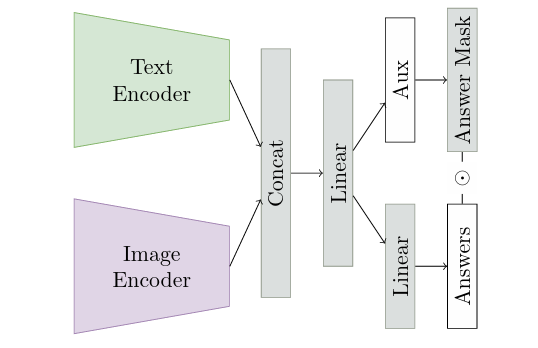

_Figure 2: Models architecture_

a. You will need to follow the implementation of this paper.

[2206.05281v1.pdf (arxiv.org)](https://arxiv.org/pdf/2206.05281v1.pdf)

b. You are allowed to use clip model image encoder and text encoder trained by OpenAI, the following is the paper link and in it you can find the GitHub repo.

[2103.00020.pdf(arxiv.org)](https://arxiv.org/pdf/2103.00020.pdf)

c. You will closely follow the implementation in the paper to train the classification layers as stated in the paper: “Our approach utilizes both image and text encoder. The resulting features are concatenated and passed to linear layers with layer normalization and a high dropout value (0.5). As shown in Figure 2. answer types as well as the answers are predicted using an additional linear layer. Image size of the visual encoder is 448x448 for RN50x64 and 336x336 for ViT-L/14@336px. In both cases the linear classifier is trained using cross entropy loss with rotation as image augmentation. We train only the additional linear classifier and use the pre-trained CLIP model as image and text encoder. The CLIP part remains frozen and is not trained on the VizWiz data set, **which allows fast and efficient training without large computational resources**.”

d. You must modify the PyTorch code provided in the clip repo to implement this model.

**Device Configuration**

In [25]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

cuda:0
Tesla T4
time: 1.87 ms (started: 2023-06-25 15:51:05 +00:00)


#### Preparing CLIP

https://github.com/OpenAI/CLIP

In [26]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.7 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-r74x_w_e
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-r74x_w_e
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369410 sha256=5644469bcfd76a76c5218949742f009227756320b91ce298663dfb97f74b6a42
  Stored in directory: /tmp/pip-ephem-wheel-cache-2x7dk400/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
time: 27.4 s (started: 2023-06-25 15:51:05 +00:00)


In [27]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

time: 212 ms (started: 2023-06-25 15:51:32 +00:00)


**Using the RN50**

In [28]:
clip_model, preprocess = clip.load("RN50", device=device)

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in clip_model.parameters()]):,}")
print(f"Input resolution: {clip_model.visual.input_resolution}")
print(f"Context length: {clip_model.context_length}")
print(f"Vocab size: {clip_model.vocab_size}")

100%|████████████████████████████████████████| 244M/244M [00:01<00:00, 128MiB/s]


Model parameters: 102,007,137
Input resolution: 224
Context length: 77
Vocab size: 49408
time: 5.97 s (started: 2023-06-25 15:51:32 +00:00)


### Dataset Preparation

In [29]:
class VizWizDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.copy()
        self.n_samples = df.shape[0]
        self.image_path = self.df["image"].apply(lambda row:str(Path("/kaggle/input/vizwiz/data/Images/")/row))
        
        def most_common(lst):
            data = Counter(lst)
            return max(lst, key=data.get)
        
        self.df['max_answer'] = self.df["answers"].apply(lambda row:most_common([ans["answer"] for ans in row]))
#         self.df.drop(columns=['answers'], inplace=True)
        self.transform = transform
        
        self.X = torch.empty((len(self.df), 2048), dtype=torch.float32)
        for i in range(len(self.df)):
            image = Image.open(self.image_path.iloc[i]).convert('RGB')
            if self.transform is not None:
                image = self.transform(image).unsqueeze(0).to(device)

            question = clip.tokenize(self.df['question'].iloc[i]).to(device)
            with torch.no_grad():
                image_features = clip_model.encode_image(image)
                text_features = clip_model.encode_text(question)
            self.X[i] = torch.cat((image_features, text_features), 1).to(torch.float32)
                
    def __getitem__(self, index):
        return index, self.X[index], self.df['max_answer'].iloc[index], self.df['answerable'].iloc[index]
        
    def __len__(self):
        return self.n_samples

time: 1.85 ms (started: 2023-06-25 15:51:38 +00:00)


In [30]:
if os.path.exists('/kaggle/working/train_dataset.pth'):
    train_dataset = torch.load('/kaggle/working/train_dataset.pth')
else:
    train_dataset = VizWizDataset(train, transform=preprocess)
    torch.save(train_dataset, 'train_dataset.pth')

time: 20min 17s (started: 2023-06-25 15:51:38 +00:00)


In [31]:
if os.path.exists('/kaggle/working/val_dataset.pth'):
    val_dataset = torch.load('/kaggle/working/val_dataset.pth')
else:
    val_dataset = VizWizDataset(val, transform=preprocess)
    torch.save(val_dataset, 'val_dataset.pth')

time: 3min 30s (started: 2023-06-25 16:11:56 +00:00)


In [32]:
if os.path.exists('/kaggle/working/test_dataset.pth'):
    test_dataset = torch.load('/kaggle/working/test_dataset.pth')
else:
    test_dataset = VizWizDataset(test, transform=preprocess)
    torch.save(test_dataset, 'test_dataset.pth')    

time: 1min 3s (started: 2023-06-25 16:15:27 +00:00)


**Encoding Labels for the VQA Task**

In [33]:
ANSWER_CANDIDATES = train_dataset.df['max_answer'].nunique()

time: 7.17 ms (started: 2023-06-25 16:16:31 +00:00)


In [34]:
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=ANSWER_CANDIDATES)
enc.fit(np.array(train_dataset.df['max_answer']).reshape(-1, 1))

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=5318)

time: 26.8 ms (started: 2023-06-25 16:16:31 +00:00)


#### DataLoader

In [35]:
BATCH_SIZE = 32

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

time: 4.95 ms (started: 2023-06-25 16:16:31 +00:00)


### Model

#### Visual Question Answering Task

In [36]:
class VQAModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(VQAModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.ln2 = nn.LayerNorm(output_dim)
        self.dropout2 = nn.Dropout(p=0.5)

    def forward(self, x):
        # Layer 1
        x = self.fc1(x)
        x = self.ln1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        
        # Layer 2
        x = self.fc2(x)
        x = self.ln2(x)
        x = self.dropout2(x)
        return x

time: 2.34 ms (started: 2023-06-25 16:16:31 +00:00)


In [37]:
def accuracy_vqa(df, index, value):
    if value == None:
        return 0
    ans_list = [elem['answer'] for elem in df.iloc[index]['answers']]
    return np.divide(np.sum(np.minimum(np.count_nonzero(np.array(list(combinations(ans_list, 9))) == value, axis=1), 1)), 10)

time: 3.78 ms (started: 2023-06-25 16:16:31 +00:00)


In [38]:
def train_vqa(model, data_loader, criterion, optimizer):
    model.train()
    train_loss = 0
    accuracy = 0
    for i, (index, x, answers, _) in enumerate(data_loader):
        x = x.to(device) 
        answers = torch.as_tensor(enc.transform(np.array(answers).reshape(-1, 1)).astype(int)).to(device).squeeze(1)
        
        # Forward Pass
        outputs = model(x).squeeze(1)
        loss = criterion(outputs, answers)
        
        # Backward Pass
        optimizer.zero_grad()
        loss.backward()
        
        # Update Weights
        optimizer.step()

        # Loss and Accuracy Calculations
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        predicted = enc.inverse_transform(np.array(predicted.to('cpu')).reshape(-1,1))
        for ip, idx in enumerate(index):
            accuracy += accuracy_vqa(data_loader.dataset.df, int(idx), predicted[ip])

    train_loss /= len(data_loader.dataset)
    accuracy /= len(data_loader.dataset)
    
    return train_loss, accuracy

time: 1.42 ms (started: 2023-06-25 16:16:31 +00:00)


In [39]:
def validate_vqa(model, data_loader, criterion):
    model.eval()
    val_loss = 0
    accuracy = 0
    with torch.no_grad():
        for i, (index, x, answers, _) in enumerate(data_loader):
            x = x.to(device)
            answers = torch.as_tensor(enc.transform(np.array(answers).reshape(-1, 1)).astype(int)).to(device).squeeze(1)
            
            # Forward Pass
            outputs = model(x).squeeze(1)
            loss = criterion(outputs, answers)
            
            # Loss and Accuracy Calculations
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            predicted = enc.inverse_transform(np.array(predicted.to('cpu')).reshape(-1,1))
            for ip, idx in enumerate(index):
                accuracy += accuracy_vqa(data_loader.dataset.df, int(idx), predicted[ip])

    val_loss /= len(data_loader.dataset)
    accuracy /= len(data_loader.dataset)

    return val_loss, accuracy

time: 8.74 ms (started: 2023-06-25 16:16:31 +00:00)


In [40]:
NUM_EPOCHS = 30
LEARNING_RATE = 0.0001

time: 6.23 ms (started: 2023-06-25 16:16:31 +00:00)


In [41]:
input_dim = 2048
hidden_dim = 2048
output_dim = ANSWER_CANDIDATES + 1

model_vqa = VQAModel(input_dim, hidden_dim, output_dim).to(device)

time: 148 ms (started: 2023-06-25 16:16:31 +00:00)


In [42]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_vqa.parameters(), lr=LEARNING_RATE)

time: 739 µs (started: 2023-06-25 16:16:31 +00:00)


In [43]:
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, verbose=False)

time: 2.76 ms (started: 2023-06-25 16:16:31 +00:00)


In [44]:
VQA_MODEL_NAME = 'vqa_model.pth'
checkpoint_dir = '/kaggle/working/checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    
# Define the variables for saving the best checkpoint
best_val_loss = float('inf')
patience = 10

time: 3.87 ms (started: 2023-06-25 16:16:31 +00:00)


In [45]:
# Defining Lists to store training and validation accuracies and losses
train_vqa_acc_history = []
train_vqa_loss_history = []
val_vqa_acc_history = []
val_vqa_loss_history = []

counter = 0

for epoch in range(NUM_EPOCHS):
    print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}]:")
    start_time = time.perf_counter()
    
    train_loss, train_acc = train_vqa(model_vqa, train_loader, criterion, optimizer)
    val_loss, val_acc = validate_vqa(model_vqa, val_loader, criterion)
    
    epoch_time = time.perf_counter() - start_time
    avg_step_time = epoch_time / (len(train_loader) + len(val_loader))
        
    train_vqa_acc_history.append(train_acc)
    train_vqa_loss_history.append(train_loss)
    val_vqa_acc_history.append(val_acc)
    val_vqa_loss_history.append(val_loss)
    
     # Check if the validation loss has improved
    if val_loss < best_val_loss:
        print(f"val_loss improved from {best_val_loss:.5f} to {val_loss:.5f}, saving model to {VQA_MODEL_NAME}")
        best_val_loss = val_loss
        counter = 0
        # Save the model checkpoint
        checkpoint_path_vqa = os.path.join(checkpoint_dir, VQA_MODEL_NAME)
        torch.save(model_vqa, checkpoint_path_vqa)
    else:
        counter += 1
        if counter >= patience:
            print(f"val_loss hasn't improved for {patience} epochs. Early stopping.")
            break
    
    print(f"{int(np.round(epoch_time))}s {avg_step_time*1e3:.4f}ms/step - loss: {train_loss:.4f} - accuracy: {train_acc*100:.4f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc*100:.4f}% - lr: {optimizer.param_groups[0]['lr']}")
    
    lr_scheduler.step(val_loss)
    print()

Epoch [1/30]:
val_loss improved from inf to 0.20902, saving model to vqa_model.pth
18s 26.5144ms/step - loss: 0.2345 - accuracy: 34.7195% - val_loss: 0.2090 - val_accuracy: 49.8078% - lr: 0.0001

Epoch [2/30]:
val_loss improved from 0.20902 to 0.20426, saving model to vqa_model.pth
18s 25.3791ms/step - loss: 0.2199 - accuracy: 36.5879% - val_loss: 0.2043 - val_accuracy: 51.7617% - lr: 0.0001

Epoch [3/30]:
val_loss improved from 0.20426 to 0.19971, saving model to vqa_model.pth
18s 26.1323ms/step - loss: 0.2134 - accuracy: 37.6453% - val_loss: 0.1997 - val_accuracy: 52.1525% - lr: 0.0001

Epoch [4/30]:
val_loss improved from 0.19971 to 0.19429, saving model to vqa_model.pth
18s 25.6616ms/step - loss: 0.2068 - accuracy: 38.8889% - val_loss: 0.1943 - val_accuracy: 54.1286% - lr: 0.0001

Epoch [5/30]:
val_loss improved from 0.19429 to 0.19083, saving model to vqa_model.pth
18s 26.3492ms/step - loss: 0.2029 - accuracy: 39.6932% - val_loss: 0.1908 - val_accuracy: 54.0782% - lr: 0.0001

Epoc

**Loading the best model**

In [46]:
model_vqa = torch.load(checkpoint_path_vqa)
model_vqa.eval()

VQAModel(
  (fc1): Linear(in_features=2048, out_features=2048, bias=True)
  (ln1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=2048, out_features=5319, bias=True)
  (ln2): LayerNorm((5319,), eps=1e-05, elementwise_affine=True)
  (dropout2): Dropout(p=0.5, inplace=False)
)

time: 55.2 ms (started: 2023-06-25 16:22:52 +00:00)


In [47]:
train_loss_vqa, train_acc_vqa = validate_vqa(model_vqa, train_loader, criterion)
print(f"Training Loss: {train_loss_vqa:.4f}")
print(f"Training Accuracy: {train_acc_vqa*100:.4f}%")

Training Loss: 0.1421
Training Accuracy: 70.3058%
time: 12.4 s (started: 2023-06-25 16:22:52 +00:00)


In [48]:
val_loss_vqa, val_acc_vqa = validate_vqa(model_vqa, val_loader, criterion)
print(f"Validation Loss: {val_loss_vqa:.4f}")
print(f"Validation Accuracy: {val_acc_vqa*100:.4f}%")

Validation Loss: 0.1773
Validation Accuracy: 58.2351%
time: 2.04 s (started: 2023-06-25 16:23:05 +00:00)


In [49]:
test_loss_vqa, test_acc_vqa = validate_vqa(model_vqa, test_loader, criterion)
print(f"Test Loss: {test_loss_vqa:.4f}")
print(f"Test Accuracy: {test_acc_vqa*100:.4f}%")

Test Loss: 0.1790
Test Accuracy: 60.2700%
time: 663 ms (started: 2023-06-25 16:23:07 +00:00)


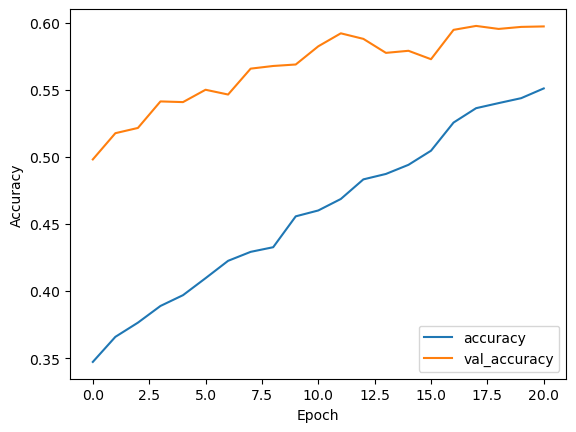

time: 330 ms (started: 2023-06-25 16:23:07 +00:00)


In [50]:
plt.plot(train_vqa_acc_history, label='accuracy')
plt.plot(val_vqa_acc_history, label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

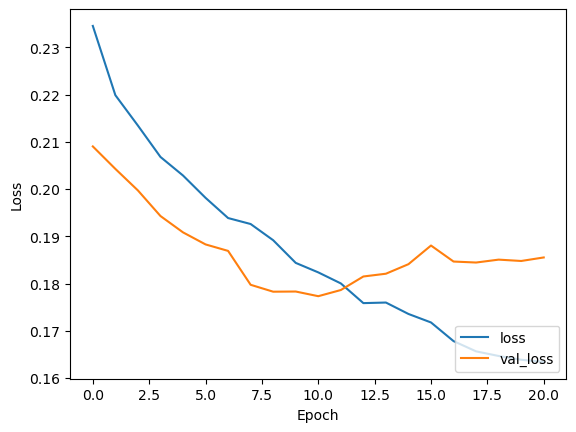

time: 335 ms (started: 2023-06-25 16:23:08 +00:00)


In [51]:
plt.plot(train_vqa_loss_history, label='loss')
plt.plot(val_vqa_loss_history, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

#### Answerability Task

In [52]:
class AnsModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(AnsModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(p=0.5)
        self.activation = nn.SiLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.norm(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

time: 1.35 ms (started: 2023-06-25 16:23:08 +00:00)


In [53]:
def train_ans(model, data_loader, criterion, optimizer):
    model.train()
    train_loss = 0
    train_scores = []
    train_targets = []

    for i, (_, x, _, targets) in enumerate(data_loader):
        x = x.to(device)
        targets = targets.to(device)
        
        # Forward Pass
        outputs = model(x).squeeze(1)
        loss = criterion(outputs, targets.float())
        
        # Backward Pass
        optimizer.zero_grad()
        loss.backward()
        
        # Update Weights
        optimizer.step()

        # Loss and Accuracy Calculations
        train_loss += loss.item()
        train_scores.append(outputs.detach().cpu().numpy())
        train_targets.append(targets.cpu().numpy())
    
    train_loss /= len(data_loader.dataset)
    
    train_targets = np.concatenate(train_targets)
    train_scores = np.concatenate(train_scores)
    accuracy = average_precision_score(train_targets, train_scores)
    
    return train_loss, accuracy

time: 2.13 ms (started: 2023-06-25 16:23:08 +00:00)


In [54]:
def validate_ans(model, data_loader, criterion):
    model.eval()
    val_loss = 0
    val_scores = []
    val_targets = []
    
    with torch.no_grad():
        for i, (_, x, _, targets) in enumerate(data_loader):
            x = x.to(device)
            targets = targets.to(device)
            
            # Forward Pass
            outputs = model(x).squeeze(1)
            loss = criterion(outputs, targets.float())
            
            # Loss and Accuracy Calculations
            val_loss += loss.item()
            val_scores.append(outputs.cpu().numpy())
            val_targets.append(targets.cpu().numpy())            

    val_loss /= len(data_loader.dataset)
    
    val_targets = np.concatenate(val_targets)
    val_scores = np.concatenate(val_scores)
    accuracy = average_precision_score(val_targets, val_scores)

    return val_loss, accuracy

time: 4.92 ms (started: 2023-06-25 16:23:08 +00:00)


In [55]:
NUM_EPOCHS = 30
LEARNING_RATE = 0.0001

time: 4.2 ms (started: 2023-06-25 16:23:08 +00:00)


In [56]:
input_dim = 2048
hidden_dim = 2048
output_dim = 1

model_ans = AnsModel(input_dim, hidden_dim, output_dim).to(device)

time: 37.7 ms (started: 2023-06-25 16:23:08 +00:00)


In [57]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_ans.parameters(), lr=LEARNING_RATE)

time: 648 µs (started: 2023-06-25 16:23:08 +00:00)


In [58]:
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, verbose=False)

time: 5.18 ms (started: 2023-06-25 16:23:08 +00:00)


In [59]:
ANS_MODEL_NAME = 'ans_model.pth'
checkpoint_dir = '/kaggle/working/checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    
# Define the variables for saving the best checkpoint
best_val_loss = float('inf')
patience = 10

time: 4.38 ms (started: 2023-06-25 16:23:08 +00:00)


In [60]:
# Defining Lists to store training and validation accuracies and losses
train_ans_acc_history = []
train_ans_loss_history = []
val_ans_acc_history = []
val_ans_loss_history = []

counter = 0

for epoch in range(NUM_EPOCHS):
    print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}]:")
    start_time = time.perf_counter()
    
    train_loss, train_acc = train_ans(model_ans, train_loader, criterion, optimizer)
    val_loss, val_acc = validate_ans(model_ans, val_loader, criterion)
    
    epoch_time = time.perf_counter() - start_time
    avg_step_time = epoch_time / (len(train_loader) + len(val_loader))
        
    train_ans_acc_history.append(train_acc)
    train_ans_loss_history.append(train_loss)
    val_ans_acc_history.append(val_acc)
    val_ans_loss_history.append(val_loss)
    
     # Check if the validation loss has improved
    if val_loss < best_val_loss:
        print(f"val_loss improved from {best_val_loss:.5f} to {val_loss:.5f}, saving model to {ANS_MODEL_NAME}")
        best_val_loss = val_loss
        counter = 0
        # Save the model checkpoint
        checkpoint_path_ans = os.path.join(checkpoint_dir, ANS_MODEL_NAME)
        torch.save(model_ans, checkpoint_path_ans)
    else:
        counter += 1
        if counter >= patience:
            print(f"val_loss hasn't improved for {patience} epochs. Early stopping.")
            break
    
    print(f"{int(np.round(epoch_time))}s {avg_step_time*1e3:.4f}ms/step - loss: {train_loss:.4f} - accuracy: {train_acc*100:.4f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc*100:.4f}% - lr: {optimizer.param_groups[0]['lr']}")
    
    lr_scheduler.step(val_loss)
    print()

Epoch [1/30]:
val_loss improved from inf to 0.01252, saving model to ans_model.pth
3s 4.2075ms/step - loss: 0.0139 - accuracy: 91.7294% - val_loss: 0.0125 - val_accuracy: 94.2243% - lr: 0.0001

Epoch [2/30]:
val_loss improved from 0.01252 to 0.01218, saving model to ans_model.pth
3s 4.0634ms/step - loss: 0.0123 - accuracy: 94.1605% - val_loss: 0.0122 - val_accuracy: 94.6199% - lr: 0.0001

Epoch [3/30]:
val_loss improved from 0.01218 to 0.01214, saving model to ans_model.pth
3s 4.1127ms/step - loss: 0.0116 - accuracy: 94.9326% - val_loss: 0.0121 - val_accuracy: 94.8402% - lr: 0.0001

Epoch [4/30]:
val_loss improved from 0.01214 to 0.01182, saving model to ans_model.pth
3s 4.1346ms/step - loss: 0.0110 - accuracy: 95.6050% - val_loss: 0.0118 - val_accuracy: 95.0274% - lr: 0.0001

Epoch [5/30]:
3s 4.1201ms/step - loss: 0.0104 - accuracy: 96.0975% - val_loss: 0.0121 - val_accuracy: 95.1379% - lr: 0.0001

Epoch [6/30]:
3s 4.0807ms/step - loss: 0.0100 - accuracy: 96.5246% - val_loss: 0.0120 -

**Loading the best model**

In [61]:
model_ans = torch.load(checkpoint_path_ans)
model_ans.eval()

AnsModel(
  (fc1): Linear(in_features=2048, out_features=2048, bias=True)
  (norm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (activation): SiLU()
  (fc2): Linear(in_features=2048, out_features=1, bias=True)
)

time: 14.5 ms (started: 2023-06-25 16:23:57 +00:00)


##### Evaluation

In [62]:
train_loss_ans, train_acc_ans = validate_ans(model_ans, train_loader, criterion)
print(f"Training Loss: {train_loss_ans:.4f}")
print(f"Training Accuracy: {train_acc_ans*100:.4f}%")

Training Loss: 0.0083
Training Accuracy: 97.7269%
time: 1.27 s (started: 2023-06-25 16:23:57 +00:00)


In [63]:
val_loss_ans, val_acc_ans = validate_ans(model_ans, val_loader, criterion)
print(f"Validation Loss: {val_loss_ans:.4f}")
print(f"Validation Accuracy: {val_acc_ans*100:.4f}%")

Validation Loss: 0.0116
Validation Accuracy: 95.4372%
time: 213 ms (started: 2023-06-25 16:23:58 +00:00)


In [64]:
test_loss_ans, test_acc_ans = validate_ans(model_ans, test_loader, criterion)
print(f"Test Loss: {test_loss_ans:.4f}")
print(f"Test Accuracy: {test_acc_ans*100:.4f}%")

Test Loss: 0.0119
Test Accuracy: 95.2504%
time: 70.2 ms (started: 2023-06-25 16:23:59 +00:00)


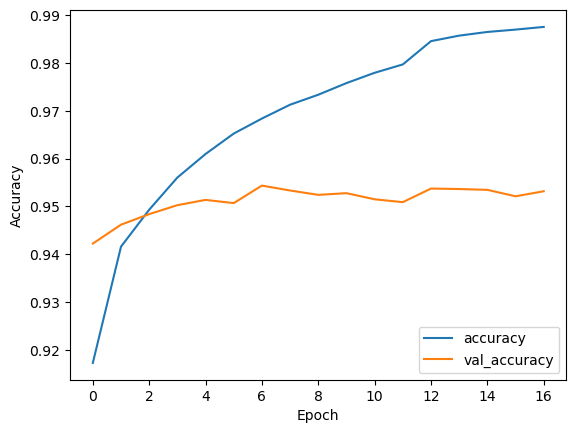

time: 327 ms (started: 2023-06-25 16:23:59 +00:00)


In [65]:
plt.plot(train_ans_acc_history, label='accuracy')
plt.plot(val_ans_acc_history, label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

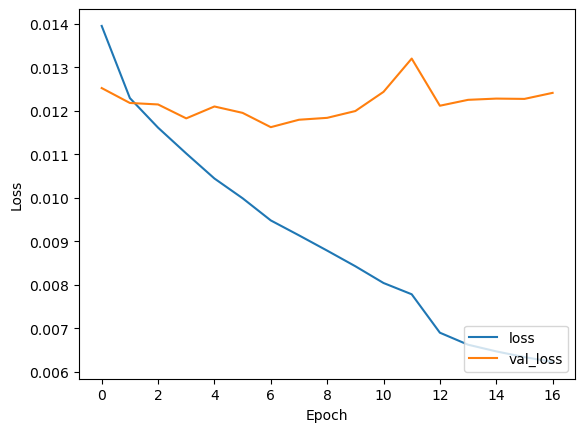

time: 351 ms (started: 2023-06-25 16:23:59 +00:00)


In [66]:
plt.plot(train_ans_loss_history, label='loss')
plt.plot(val_ans_loss_history, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

## 4. Bonus (20 Points)

In [ ]:
test_new_dir = ""
test_new = pd.read_json(test_new_dir, orient="records")

In [ ]:
test_new_dataset = VizWizDataset(test_new, transform=preprocess)

In [ ]:
test_new_loader = DataLoader(dataset=test_new_dataset, batch_size=BATCH_SIZE, shuffle=False)

**VQA**

In [ ]:
test_new_loss_vqa, test_new_acc_vqa = validate_vqa(model_vqa, test_new_loader, nn.CrossEntropyLoss())
print(f"Test Loss: {test_new_loss_vqa:.4f}")
print(f"Test Accuracy: {test_new_acc_vqa*100:.4f}%")

**Answerability**

In [ ]:
test_new_loss_ans, test_new_acc_ans = validate_ans(model_ans, test_new_loader, nn.BCEWithLogitsLoss())
print(f"Test Loss: {test_new_loss_ans:.4f}")
print(f"Test Accuracy: {test_new_acc_ans*100:.4f}%")

## Try your own example!

In [78]:
def test_single_example(image, question, clip_model, model_vqa, model_ans, encoder):
    image = preprocess(image).unsqueeze(0).to(device)
    question = clip.tokenize(question).to(device)
    with torch.no_grad():
        image_features = clip_model.encode_image(image)
        text_features = clip_model.encode_text(question)
    x = torch.cat((image_features, text_features), 1).to(torch.float32)
    
    # Visual Question Answering
    outputs_vqa = model_vqa(x).squeeze(1)
    _, predicted = outputs_vqa.max(1)
    answer = encoder.inverse_transform(np.array(predicted.to('cpu')).reshape(-1,1))
    
    # Answerability
    answerability_score = F.sigmoid(model_ans(x).squeeze(1))
    
    return answer, answerability_score

time: 1.9 ms (started: 2023-06-25 16:59:57 +00:00)


Answer: blue
Answerability Confidence: 99.554%


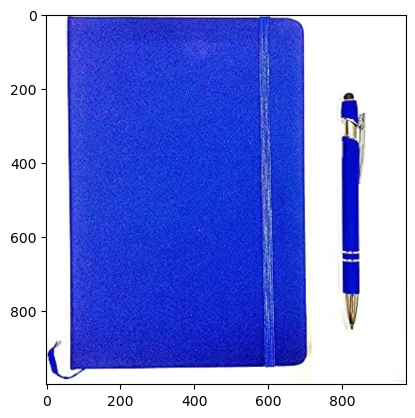

time: 636 ms (started: 2023-06-25 17:08:04 +00:00)


In [89]:
url = "https://m.media-amazon.com/images/I/41GqkUR423S._AC_UF1000,1000_QL80_.jpg"
img = Image.open(BytesIO(requests.get(url).content)).convert('RGB')
plt.imshow(img)
question = "what color is this notebook"

answer, answerability_score = test_single_example(img, question, clip_model, model_vqa, model_ans, enc)
print(f"Answer: {answer.item()}")
print(f"Answerability Confidence: {answerability_score.item()*100:.3f}%")

Answer: unanswerable
Answerability Confidence: 99.341%



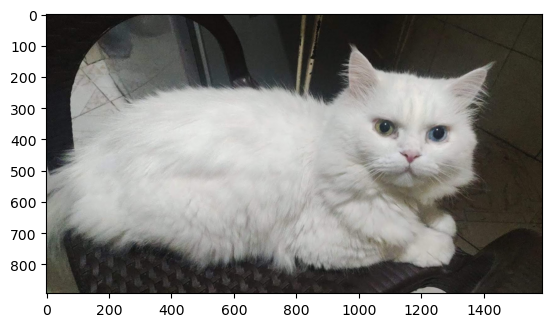

time: 706 ms (started: 2023-06-25 17:14:37 +00:00)


In [104]:
url2 = "https://lh3.googleusercontent.com/JGSaPvhTYeArKrEGrG2gDnThK79gT8_r24k4XwArPx8jKk0IQufQlhM2F3Op3VzkT11H3Ncoaq_iWMYOiJVpKSyVj7rFoFS3iEzJPVbqG9rewRlLvKRTGlrmyPhno2GNiVKS0HmJcB4SfIPZ7PJ2Bw80EbADTvs8n-FSJltME_XdMrRcogk_43Eb6xikV-Zog4jyVflZpwk6RZC9-QP8VJm9TmgE_qDZSwY-p9qxKI2Dll_e5kdJY_-TVEtigduQS09CYEu31i82Eike6Mi3alTLyOLFaIw6sWQ3WHa0bptM9SjH8KtLpg_njxbcA26rRJua1_myEsH4HNa-0wilcwO6YXwWiGul0LFAmZ7gwsXR5hDzJFj5XkFTXl-k6wIHycZUIFDps6nI8UAFc7mahKQdOqvjpW0qOwuI0p6bNLaCuLzkNCjYUsTMZvpekjWBZBGS3FEvsze3buUeyEWOfcj7U1qll2oL-bP93N8ZhW5Dnq1sDRveWD23NVNclSQnAR4gEc6RN05STrk0j5-drjw9411ly0oyayPARDgjxUr4CFP5VdWm13o7D3FNxlpENFYm2_skNDRdAR5DmFgXzJwdVl424BNpXJcDMxCm4HjkSB5vnTCAbiTX5GMPsZCkETXdINKLOTuKKdYCnVKJyT91EDASrM8xcWwQui5KpqMiqRI_IJodwt48NZ-eZxJRll_hHwEEy2RPDxbBCec1REDDWjn4-Pnh7DrhLZgRnsz6UYcnyW8dUskveoebeIHV4ghV5US_BvERlIJ1xVXlkdiTcpeDPo3fkPAp1ImVlsmlKHi3_Ea2v75qYZ5lld9FrQxwQfQ_Q3_lt8T0H57DldhRi6OHdKDqxERcP4Yog2KO5tLZY4c8faOEQ-m4xmkA61uxmgE1eweLfbAJ6hkrIdYyP7zuegpcydYOzHrbmXL409Vw4ExWbMUcRKnfr9gIooanaCNCYEqTEiQm-ua5ae0=w1588-h893-s-no?authuser=0"
img2 = Image.open(BytesIO(requests.get(url2).content)).convert('RGB')
plt.imshow(img2)
question2 = "what is the cat sitting on"

answer2, answerability_score2 = test_single_example(img2, question2, clip_model, model_vqa, model_ans, enc)
print(f"Answer: {answer2.item()}")
print(f"Answerability Confidence: {answerability_score2.item()*100:.3f}%\n")